In [2]:
from processing_utils import DataPrepare
from studu_utils import load_best_global, save_best_global, plot_feature_importance

import polars as pl
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import optuna


In [3]:
df: pl.DataFrame = pl.read_parquet(r'C:\Users\310\Desktop\Progects_Py\data\microstructure_price_prediction_data\cross_section\df_from_2024-06-15_to_2024-07-15_with_delta_0-05-00.parquet')
target_var: str = "log_return"
cols_to_exclude: list[str] = []
# File to store the best global results
BEST_GLOBAL_FILE = "best_global_RF.json"

In [4]:
data = DataPrepare(df)

In [5]:
data.train_test_split(train_test_ratio=0.7, cols_to_exclude=None)
X_train, y_train, X_test, y_test, = data.X_y_split(target_var=target_var, target_encode=True)

Train test ratio is 0.7
Train len for DOGEUSDT is 6048
Test len for DOGEUSDT is 2592
Train len for AVAXUSDT is 6048
Test len for AVAXUSDT is 2592


In [6]:
# Initialize best global results
best_global = load_best_global(BEST_GLOBAL_FILE)

In [7]:
def objective(trial, X_train, y_train, features):
    # Store the features in trial user attributes
    trial.set_user_attr("features", features)

    # Hyperparameter space
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5)
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0.0, 0.5)

    # Define the RandomForestRegressor with trial parameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        min_impurity_decrease=min_impurity_decrease,
        random_state=42,
        n_jobs=-1,
    )

    # Use K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)

    return np.mean(mse_scores)


In [8]:
def optimize_with_dataset(X_train, y_train, study_name=None):
    global best_global

    features = list(X_train.columns)

    if study_name:
        pass
    if features == best_global["features"]:
        study_name = best_global["study_name"]
    else:
        study_name = datetime.now().strftime("study_%Y-%m-%d_%H-%M-%S")
    

    # Create a new study
    study = optuna.create_study(
        study_name=study_name,
        storage="sqlite:///optuna_study_RF.db",
        direction="minimize",
        load_if_exists=True
    )

    # Run optimization
    study.optimize(lambda trial: objective(trial, X_train, y_train, features), n_trials=2)

    # Update the global best result if the current study has a better score
    if study.best_value < best_global["best_value"]:
        best_global.update(
            {
                "study_name": study_name,
                "best_value": study.best_value,
                "best_params": study.best_params,
                "features": features,
            }
        )
        # Save the updated best global results to disk
        save_best_global(best_global, BEST_GLOBAL_FILE)

    print(f"Study: {study_name}")
    print(f"Best Value: {study.best_value}")
    print(f"Best Params: {study.best_params}")

    return study


In [13]:
type(X_train)

polars.dataframe.frame.DataFrame

In [ ]:
study = optimize_with_dataset(X_train, y_train)

In [11]:
# To open dashbourd run this:
!optuna-dashboard sqlite:///optuna_study_RF.db

# And listen to:
# http://localhost:8080/


^C


In [12]:
# Test
rf_model = RandomForestRegressor(**study.best_params, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MSE on test: {mse:.4f} \nMAPE on test: {mape:.4f}")


MSE on test: 0.0000 
MAPE on test: 633064526.7184


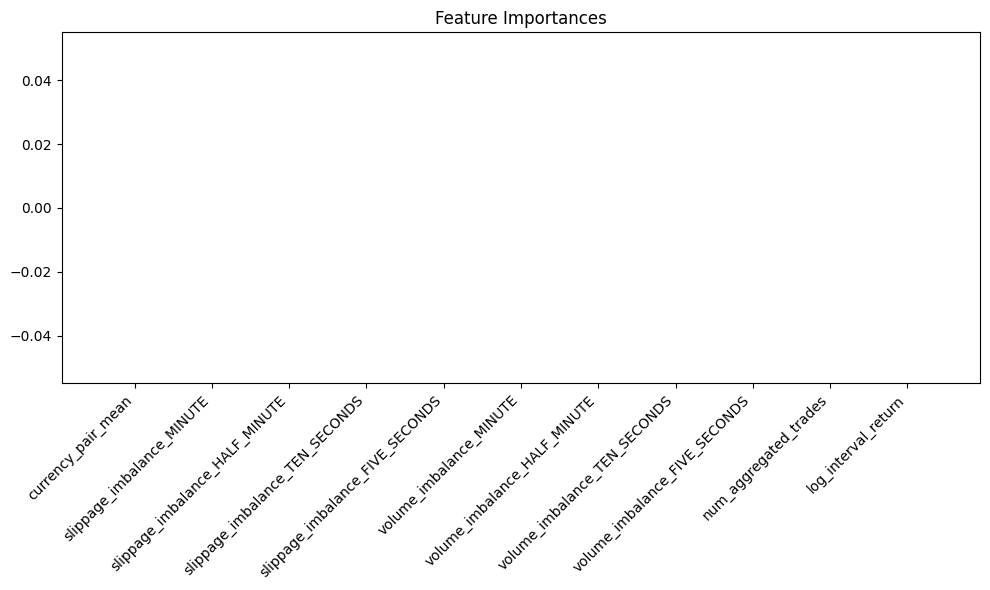

In [12]:
plot_feature_importance(rf_model, X_train.columns)